In [1]:
import os
import shutil
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
'''
if not os.path.exists('../data_for_keras/covid'):
    os.makedirs('../data_for_keras/covid')
if not os.path.exists('../data_for_keras/non_covid'):
    os.makedirs('../data_for_keras/non_covid')
'''

In [2]:
covid_chestxray = '../data/covid-chestxray-dataset/metadata.csv'

In [25]:
'''
covid_csv = pd.read_csv(covid_chestxray)
for index, row in covid_csv.iterrows():
    if (row['folder'] == "images"):
        if (row['finding'].find('COVID-19') != -1):
            shutil.copyfile(os.path.join("../data/covid-chestxray-dataset/images", row['filename']), os.path.join("../data_for_keras/covid", row['filename']))
        else:
            shutil.copyfile(os.path.join("../data/covid-chestxray-dataset/images", row['filename']), os.path.join("../data_for_keras/non_covid", row['filename']))
'''

In [ ]:
path = "../data_for_keras/covid"
for i in os.listdir(path):
    img = cv2.imread(os.path.join(path, i))
    height, width, channels = img.shape
    print(height, width, channels)

In [4]:
image_size = (240, 240)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data_for_keras",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data_for_keras",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 929 files belonging to 2 classes.
Using 744 files for training.
Found 929 files belonging to 2 classes.
Using 185 files for validation.


2022-04-11 22:49:07.055407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


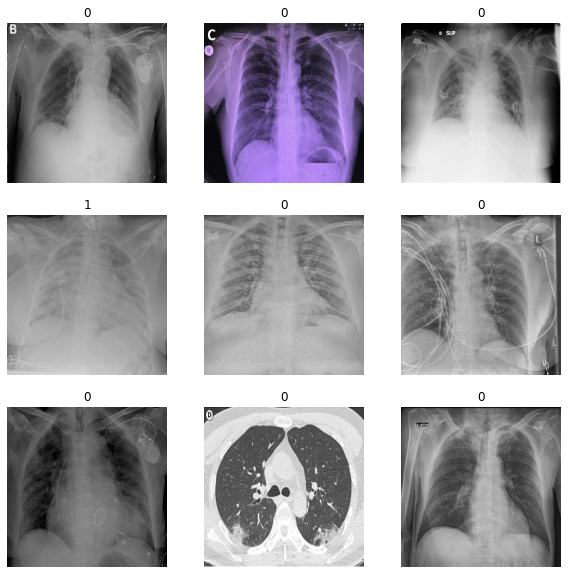

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

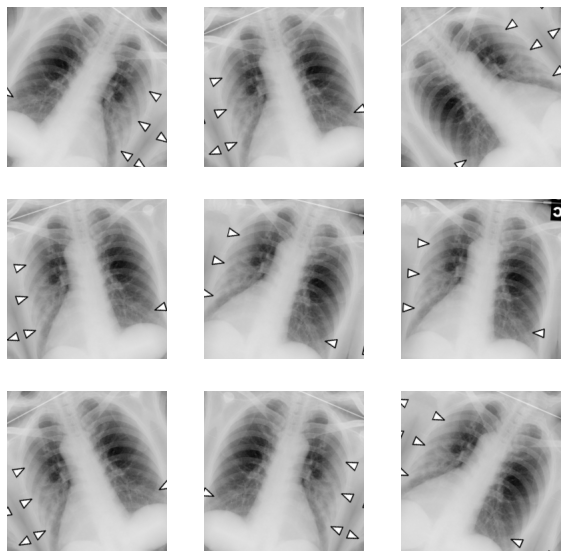

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

from sklearn.metrics import classification_report,confusion_matrix

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [13]:
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.5860

/Users/punmehta/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 142s 6s/step - loss: 0.7217 - accuracy: 0.5860 - val_loss: 0.6958 - val_accuracy: 0.4378
Epoch 2/5
24/24 [==============================] - 170s 7s/step - loss: 0.6625 - accuracy: 0.6398 - val_loss: 0.7368 - val_accuracy: 0.4378
Epoch 3/5
24/24 [==============================] - 185s 8s/step - loss: 0.6639 - accuracy: 0.6129 - val_loss: 0.7717 - val_accuracy: 0.4378
Epoch 4/5
24/24 [==============================] - 187s 8s/step - loss: 0.6385 - accuracy: 0.6465 - val_loss: 0.8828 - val_accuracy: 0.4378
Epoch 5/5
24/24 [==============================] - 182s 7s/step - loss: 0.6227 - accuracy: 0.6761 - val_loss: 0.9571 - val_accuracy: 0.4378


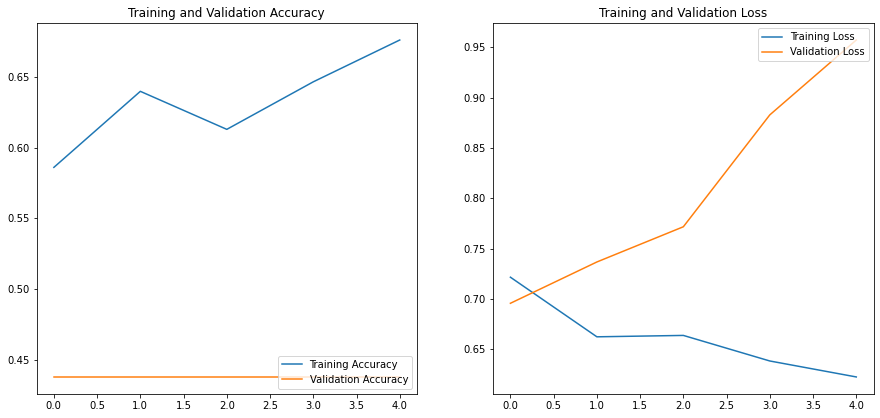

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
predictions = model.predict(val_ds)
print (val_ds.shape)
print (predictions.shape)
print (predictions[0])
#predictions = predictions.reshape(1,-1)[0]
classes_x=np.argmax(predictions,axis=1)
print (classes_x.shape)
print (classes_x[0])
print(classification_report(val_ds, classes_x, target_names = ['non_covid (Class 0)','covid (Class 1)']))

AttributeError: 'PrefetchDataset' object has no attribute 'shape'

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["non_covid", "covid"]

cm = confusion_matrix(val_ds, classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6, 185]

In [30]:
predictions = model.predict(val_ds)
#matrix = metrics.confusion_matrix(val_ds.argmax(axis=1), predictions.argmax(axis=1))
y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(val_ds, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [6, 185]